# Predicción de tópicos
Se desea extraer los tópicos principales de cada semana dentro del ámbito político

## Librerias

In [1]:
import pandas as pd
import numpy as np
import re # expresiones regulares (regex)
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import TreebankWordTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler

# Preprocesamiento

* Eliminamos stopwords
* Normalizamos el texto (quitamos mayúsculas y signos de puntuación)
* lematizamos
* Vectorizamos y hacemos n-gramas
* Usamos SVD para ver cuantos topicos pueden tener los documentos

In [2]:
# Archivo npr.csv es para hacer pruebas

df = pd.read_csv('noticias-economicas-sample.csv')

textoPrueba = df[['text']].copy() # Pongo .copy() porque cuando intentas 
                                  # quitar las stopwords sale un warning.
textoPrueba = textoPrueba.head(1000)

print(textoPrueba.shape)
textoPrueba.head(10)

(1000, 1)


,text
0,Angela Merkel ayer en Berlin tras la cumbre te...
1,\n\n\n\n\nEnrique Quemada Clariana\nFusiones y...
2,¿Cuántas veces no ha querido ser su propio jef...
3,"El ministro de Sanidad, Salvador Illa, momento..."
4,El Pleno del Congreso ha aprobado el proyecto ...
5,Vacunarse de la gripe para aliviar los hospita...
6,"Elon Musk, fundador de Tesla. EFE\n\nLa compañ..."
7,Una usuaria consulta la aplicación de banca ar...
8,Las consecuencias socioeconómicas de la pandem...
9,La aerolínea Ryanair anunció este viernes que ...


Eliminamos stopwords

In [3]:
# Función para eliminar stopwords en español

def noStopwords(text):
    
    sw_es = set(stopwords.words('spanish'))

    text = ' '.join([word for word in text.split() if word.lower() not in sw_es])
    
    return text


In [4]:
textoPrueba['text'] = textoPrueba['text'].apply(noStopwords)
textoPrueba.head()

,text
0,Angela Merkel ayer Berlin tras cumbre telemáti...
1,Enrique Quemada Clariana Fusiones adquisicione...
2,¿Cuántas veces querido ser propio jefe? ¿Cuánt...
3,"ministro Sanidad, Salvador Illa, momentos rued..."
4,Pleno Congreso aprobado proyecto Presupuestos ...


Normalizamos el texto, quitamos mayúsculas y signos de puntuación

In [5]:
# Función para normalizar el texto

def noPuntuacion(text):

    text = text.lower()

    text = re.sub('[áäàâ]', 'a', text)
    text = re.sub('[éëèê]', 'e', text)
    text = re.sub('[íïìî]', 'i', text)
    text = re.sub('[óöòô]', 'o', text)
    text = re.sub('[úüùû]', 'u', text)

    return re.findall(r'[a-zñ]+', text)

In [6]:
textoPrueba['text'] = textoPrueba['text'].apply(noPuntuacion).apply(lambda x: " ".join(x))
textoPrueba.head()

,text
0,angela merkel ayer berlin tras cumbre telemati...
1,enrique quemada clariana fusiones adquisicione...
2,cuantas veces querido ser propio jefe cuantas ...
3,ministro sanidad salvador illa momentos rueda ...
4,pleno congreso aprobado proyecto presupuestos ...


Aplicamos lematización

In [7]:
# Función para lematizar al texto
def lemmatize_text(text):

    # Cargamos el módulo de español
    nlp = spacy.load("es_core_news_sm")

    # nlp crea una pipeline que le adhiere metadata que la paquetería spacy usa
    doc = nlp(text)

    lemmatized_text = " ".join([token.lemma_ for token in doc])
    
    return lemmatized_text

In [8]:
textoPrueba['text'] = textoPrueba['text'].apply(lemmatize_text)
textoPrueba.head()

,text
0,angelar merkel ayer berlin tras cumbre telemat...
1,enrique quemado clarián fusión adquisición act...
2,cuanta vez querido ser propio jefe cuanta vez ...
3,ministro sanidad salvador illa momento rodar p...
4,pleno congreso aprobado proyecto presupuesto g...


Aplicamos stemming (Esta madre lo mas probable es que no lo pongamos)

In [106]:
# # Función para aplicar stemming al texto

# def stemmiar(text):

#     stemmer = SnowballStemmer('spanish')

#     return ' '.join([stemmer.stem(word) for word in text.split()])

In [ ]:
# textoPrueba['text'] = textoPrueba['text'].apply(stemmiar)
# textoPrueba.head()

Vectorizamos y hacemos n-gramas

In [9]:
# Creamos una instancia que hará la vectorización TF-IDF
vect = TfidfVectorizer()

# Tokenizamos como Penn Treebank
tokenizer = TreebankWordTokenizer()
vect.set_params(tokenizer=tokenizer.tokenize)

# Incluimos 1-grams y 2-grams
vect.set_params(ngram_range=(1, 2))

# Ignoramos términos que aparecen en más del 70% de los documentos
vect.set_params(max_df=0.7)

# Solo mantenemos los términos que aparecen en al menos 2 documentos
vect.set_params(min_df=2)

TfidfVectorizer(max_df=0.7, min_df=2, ngram_range=(1, 2),
                tokenizer=<bound method TreebankWordTokenizer.tokenize of <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x000001C7F40909D0>>)

In [10]:
# Lo aplicamos
vectFit = vect.fit_transform(textoPrueba['text']) 
vectFit 

c:\Users\Victor Minjares\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<1000x36755 sparse matrix of type '<class 'numpy.float64'>'
	with 260367 stored elements in Compressed Sparse Row format>

In [11]:
print(vectFit[1])

  (0, 34513)	0.05977278102484332
  (0, 14097)	0.0445481467104263
  (0, 26038)	0.0572477886997856
  (0, 26053)	0.0572477886997856
  (0, 34894)	0.05977278102484332
  (0, 33336)	0.05977278102484332
  (0, 30100)	0.052336027749666225
  (0, 17669)	0.05977278102484332
  (0, 34682)	0.05977278102484332
  (0, 29347)	0.0572477886997856
  (0, 13841)	0.05977278102484332
  (0, 8991)	0.03748814756365057
  (0, 20992)	0.0572477886997856
  (0, 28065)	0.0572477886997856
  (0, 11936)	0.05977278102484332
  (0, 25758)	0.05977278102484332
  (0, 11920)	0.05116401957182712
  (0, 7225)	0.05528925249468737
  (0, 6530)	0.0572477886997856
  (0, 35097)	0.0572477886997856
  (0, 13225)	0.05977278102484332
  (0, 36403)	0.0572477886997856
  (0, 645)	0.0411631780336722
  (0, 2370)	0.05977278102484332
  (0, 25080)	0.05977278102484332
  :	:
  (0, 2821)	0.04404646596602561
  (0, 531)	0.03490560077956706
  (0, 812)	0.045646706563828146
  (0, 15207)	0.045646706563828146
  (0, 28026)	0.11057850498937474
  (0, 12263)	0.0837900

Descomposicion por valores singulares (SVD)

Hacemos z-score normalizacion

In [12]:
# Creamos la instancia 
scaler = StandardScaler(with_mean=False)
# Calculamos el promedio y la desviacion estandar
scaler.fit(vectFit)
# Re escalamos
vectFitScaled = scaler.transform(vectFit)

print(vectFitScaled[0])

  (0, 30699)	9.27138409131152
  (0, 24595)	20.181006126903316
  (0, 3537)	1.9275034143473373
  (0, 20953)	12.290306810752938
  (0, 25176)	30.726390786514667
  (0, 21545)	2.939505106782944
  (0, 34368)	10.459369803814978
  (0, 3367)	3.282291150123428
  (0, 25032)	10.563285269318952
  (0, 21757)	6.391329437543724
  (0, 31192)	12.711982566074031
  (0, 30588)	26.024510896800184
  (0, 35064)	4.473469645889671
  (0, 11120)	20.436860535190583
  (0, 34356)	7.458483167930656
  (0, 15010)	17.39644617764987
  (0, 4194)	21.92470156938827
  (0, 18247)	21.84194032704319
  (0, 13449)	24.69451113024058
  (0, 14126)	15.712340486181539
  (0, 36495)	26.62544462522572
  (0, 15414)	8.782099289345757
  (0, 29453)	15.69349034657133
  (0, 7416)	14.623141983744377
  (0, 6870)	19.07286223297439
  :	:
  (0, 18142)	13.10413571051665
  (0, 16153)	1.4585567505519994
  (0, 7858)	2.4834188040029366
  (0, 17630)	8.457757246916279
  (0, 23602)	5.004043242454465
  (0, 9026)	2.6702326007827133
  (0, 7218)	2.8830930534470

In [44]:
# vectFitScaled = vectFitScaled.transpose()
# vectFitScaled

<36755x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 260367 stored elements in Compressed Sparse Column format>

In [13]:
# Creamos instancia de la clase TruncatedSVD
dimReduction = TruncatedSVD(n_components = 1000, random_state = 2)

In [14]:
# Ajustamos la transfromacion con nuestros datos
dimReduction.fit(vectFitScaled)

TruncatedSVD(n_components=1000, random_state=2)

In [15]:
# Reducimos la dimensionalidad
dataReduction = dimReduction.transform(vectFitScaled)

In [16]:
print("Variancia explicada por los 36,755 componentes = " \
        + str(sum(dimReduction.explained_variance_ratio_ * 100)))

Variancia explicada por los 36,755 componentes = 99.99999999999983


In [17]:
dimReduction.explained_variance_ratio_ * 100

array([2.92907403e+00, 1.08747251e+00, 8.91823123e-01, 8.93097688e-01,
       7.82397797e-01, 3.26826811e-01, 6.22625312e-01, 6.04288519e-01,
       5.31834422e-01, 4.77400122e-01, 4.63635079e-01, 3.07387531e-01,
       2.82884596e-01, 2.47786414e-01, 2.42557739e-01, 2.40058660e-01,
       2.39514033e-01, 2.31188088e-01, 2.29010999e-01, 2.19731003e-01,
       2.17094304e-01, 2.15323707e-01, 2.12431769e-01, 2.11292788e-01,
       2.09540361e-01, 2.07904365e-01, 2.04660966e-01, 2.02536569e-01,
       1.99086929e-01, 1.97339058e-01, 1.95179640e-01, 1.94160298e-01,
       1.92345963e-01, 1.90270805e-01, 1.89645666e-01, 1.89097159e-01,
       1.88074845e-01, 1.87157629e-01, 1.86080424e-01, 1.84984712e-01,
       1.83812047e-01, 1.82769478e-01, 1.81462165e-01, 1.79489851e-01,
       1.78932863e-01, 1.78102459e-01, 1.77834634e-01, 1.77676090e-01,
       1.76377923e-01, 1.75246266e-01, 1.74692521e-01, 1.73202107e-01,
       1.72894986e-01, 1.72188896e-01, 1.72154962e-01, 1.71199666e-01,
      

In [18]:
np.cumsum(dimReduction.explained_variance_ratio_ * 100)

array([  2.92907403,   4.01654654,   4.90836966,   5.80146735,
         6.58386515,   6.91069196,   7.53331727,   8.13760579,
         8.66944021,   9.14684034,   9.61047542,   9.91786295,
        10.20074754,  10.44853396,  10.69109169,  10.93115035,
        11.17066439,  11.40185247,  11.63086347,  11.85059448,
        12.06768878,  12.28301249,  12.49544426,  12.70673704,
        12.91627741,  13.12418177,  13.32884274,  13.53137931,
        13.73046624,  13.92780529,  14.12298493,  14.31714523,
        14.5094912 ,  14.699762  ,  14.88940767,  15.07850483,
        15.26657967,  15.4537373 ,  15.63981772,  15.82480244,
        16.00861448,  16.19138396,  16.37284613,  16.55233598,
        16.73126884,  16.9093713 ,  17.08720593,  17.26488202,
        17.44125995,  17.61650621,  17.79119873,  17.96440084,
        18.13729583,  18.30948472,  18.48163968,  18.65283935,
        18.8234315 ,  18.99318808,  19.16280035,  19.33179074,
        19.5000421 ,  19.66795457,  19.83509238,  20.00

Text(0, 0.5, 'Variancia explicada (%)')

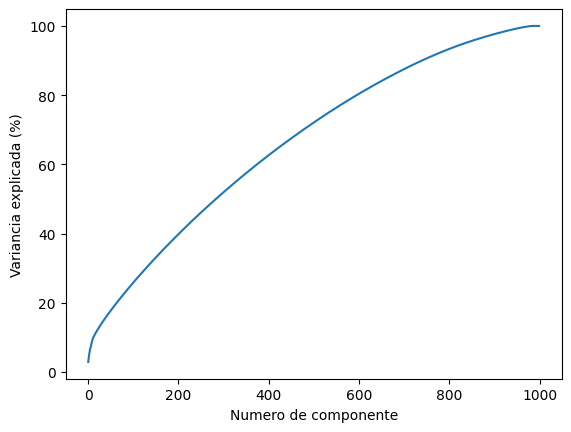

In [19]:
plt.plot(np.cumsum(dimReduction.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componente")
plt.ylabel("Variancia explicada (%)")

In [20]:
# Creamos instancia de la clase TruncatedSVD
dimReduction2 = TruncatedSVD(n_components = 2, random_state = 2)

# Ajustamos la transfromacion con nuestros datos
dimReduction2.fit(vectFitScaled)

# Reducimos la dimensionalidad
dataReduction2 = dimReduction2.transform(vectFitScaled)

print("Variancia explicada por 2 componentes = " \
        + str(sum(dimReduction2.explained_variance_ratio_ * 100)))

Variancia explicada por 2 componentes = 4.01650050481225


Text(0, 0.5, 'Segundo componente')

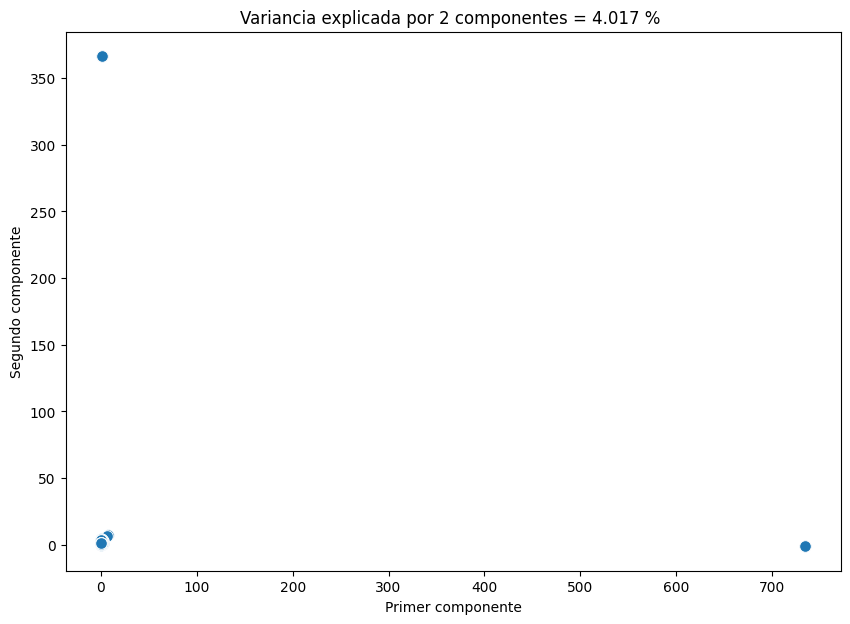

In [21]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=dataReduction2[:,0], y=dataReduction2[:,1], s=70)
plt.title(f"Variancia explicada por 2 componentes = {round(sum(dimReduction2.explained_variance_ratio_ * 100),3)} % ")
plt.xlabel("Primer componente")
plt.ylabel("Segundo componente")

Estandarizamos la matriz para meterla al LDA

In [22]:
scaler = MaxAbsScaler()
scaler.fit(vectFit)
vectFitStandardized = scaler.transform(vectFit)

In [23]:
print(vectFitStandardized[1])

  (0, 34513)	1.0
  (0, 14097)	0.9886644487700367
  (0, 26038)	1.0
  (0, 26053)	0.30620364900687713
  (0, 34894)	1.0
  (0, 33336)	1.0
  (0, 30100)	0.15010129635749356
  (0, 17669)	1.0
  (0, 34682)	1.0
  (0, 29347)	1.0
  (0, 13841)	0.17615884346114774
  (0, 8991)	0.28669476954689166
  (0, 20992)	1.0
  (0, 28065)	1.0
  (0, 11936)	0.7912294111977892
  (0, 25758)	1.0
  (0, 11920)	0.4416417975985148
  (0, 7225)	0.8015278766073097
  (0, 6530)	1.0
  (0, 35097)	0.9405734432758843
  (0, 13225)	0.3908790750071285
  (0, 36403)	1.0
  (0, 645)	0.5021927636235246
  (0, 2370)	1.0
  (0, 25080)	0.39149808798501645
  :	:
  (0, 2821)	0.3136870767906291
  (0, 531)	0.32590664206304676
  (0, 812)	0.24976317239422824
  (0, 15207)	0.2903316075510571
  (0, 28026)	1.0
  (0, 12263)	0.3364911652706787
  (0, 22163)	0.34587070809595266
  (0, 11790)	0.2687266071979054
  (0, 3356)	0.07215510438750433
  (0, 31060)	0.31130577569261475
  (0, 35054)	0.09467414231343586
  (0, 27708)	0.11027100956387959
  (0, 20448)	0.29208